<a href="https://colab.research.google.com/github/nepalprabin/fastai/blob/master/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt')]

In [0]:
path_label = path/'labels'
path_images = path/'images'

**Data**

In [5]:
fnames = get_image_files(path_images)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_08131.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_06420.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f04350.png')]

In [6]:
label_names = get_image_files(path_label)
label_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_07560_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08049_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_007830_P.png')]

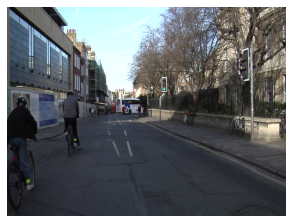

In [10]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_label/f'{x.stem}_P{x.suffix}'

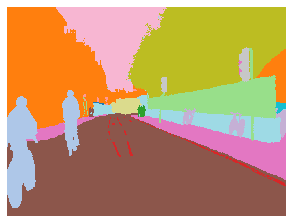

In [12]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [13]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [14]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

**Creating dataset for training**

In [0]:
size = src_size//2
bs = 8

In [0]:
src = (SegmentationItemList.from_folder(path_images)
        .split_by_fname_file('../valid.txt')
        .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

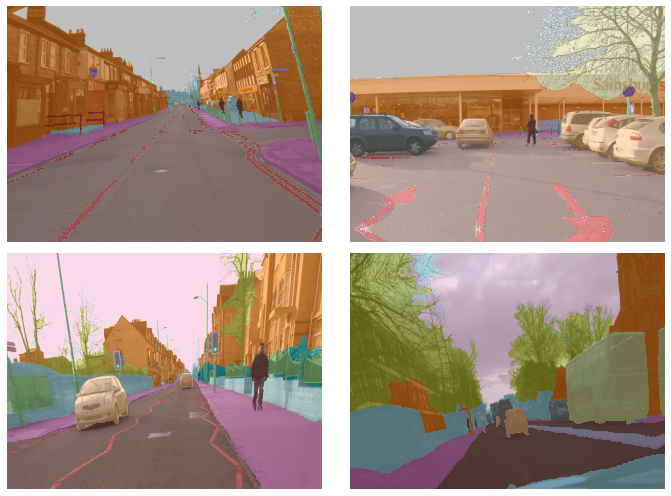

In [23]:
data.show_batch(2, figsize=(10,7))

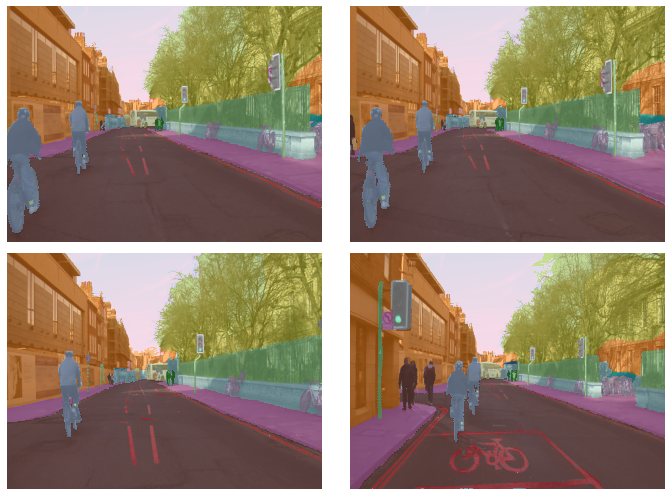

In [24]:
# Validation dataset
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

**Model**

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics = acc_camvid
# metrics = accuracy

In [0]:
wd=1e-2

In [28]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [29]:
lr_find(learn)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


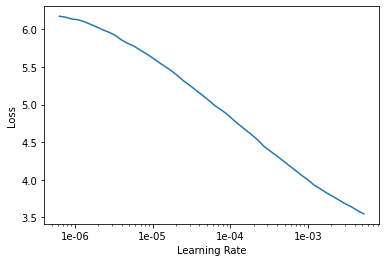

In [31]:
learn.recorder.plot()

In [0]:
lr=3e-3

In [33]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.454063,1.035394,0.781479,01:24
1,0.961690,0.714627,0.835417,01:24
2,0.762466,0.557555,0.849739,01:25
3,0.740887,0.782043,0.818973,01:26
4,0.681222,0.573591,0.860603,01:26
5,0.598071,0.430756,0.877266,01:26
6,0.598860,0.538832,0.861044,01:26
7,0.569103,0.476227,0.870634,01:25
8,0.564498,0.430291,0.876715,01:25
9,0.484706,0.358410,0.895672,01:25


In [0]:
learn.save('stage-1')

In [35]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

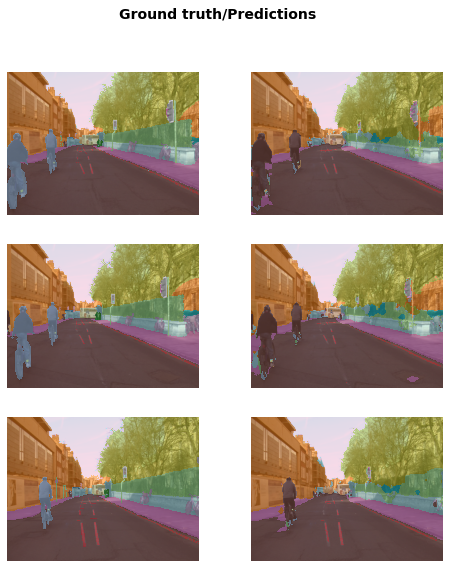

In [37]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400, lr/4)

In [40]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.405578,0.337276,0.900100,01:24
1,0.398677,0.327985,0.902601,01:27
2,0.386992,0.312767,0.907790,01:28
3,0.375709,0.319286,0.904127,01:29
4,0.363422,0.292076,0.921389,01:30
5,0.349277,0.311364,0.908322,01:30
6,0.338654,0.300247,0.912777,01:30
7,0.327522,0.312791,0.909944,01:30
8,0.326224,0.336082,0.901240,01:30
9,0.309445,0.275988,0.921804,01:30


In [0]:
learn.save('stage-2')

In [42]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

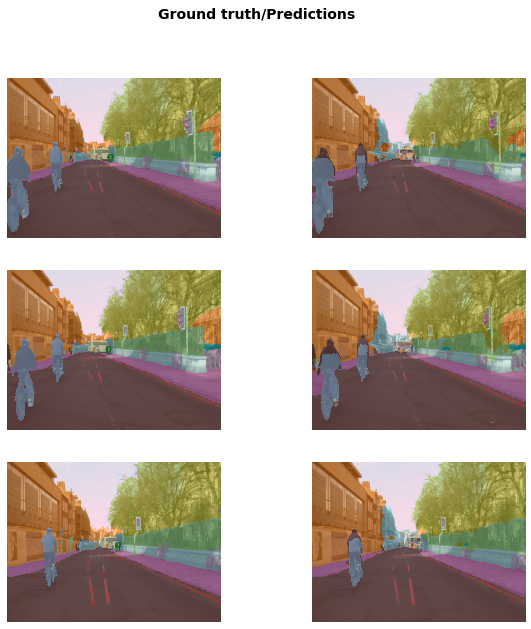

In [43]:
learn.show_results(rows=3, figsize=(10,10))